# Unity ML Agents
## Environment Basics
This notebook contains a walkthrough of the basic functions of the Python API for Unity ML Agents. For instructions on building a Unity environment, see [here](https://github.com/Unity-Technologies/ml-agents/wiki/Getting-Started-with-Balance-Ball).

### 1. Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import os
import time

from unityagents import UnityEnvironment

%matplotlib inline

### 2. Set environment parameters

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "./ML_Agent_Pong//ML_Agent_Pong" # Name of the Unity environment binary to launch
train_mode = True # Whether to run the environment in training or inference mode

### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 1
        State space type: discrete
        State space size (per agent): 1
        Action space type: discrete
        Action space size (per agent): 3
        Memory space size (per agent): 0
        Action descriptions: s, a, d


### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Agent state looks like: 
[ 0.]
Agent observations look like:


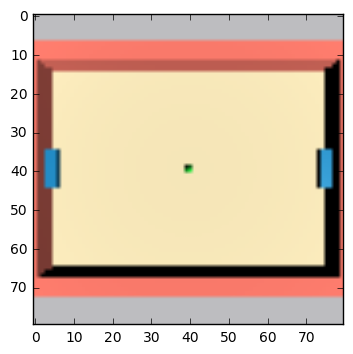

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.states[0]))

# Examine the observation space for the default brain
for observation in env_info.observations:
    print("Agent observations look like:")
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

### 5. Parameters

In [5]:
import random

Gamma = 0.99
Learning_rate = 0.00025
Epsilon = 1
Final_epsilon = 0.1

algorithm = 'DQN'
Num_action = brain.action_space_size

Num_replay_memory = 50000
Num_start_training = 25000
Num_training = 500000
Num_update = 5000
Num_batch = 32
Num_test = 10000
Num_skipFrame = 4
Num_stackFrame = 4
Num_colorChannel = 1

Num_plot_episode = 20
Num_step_save = 50000

GPU_fraction = 0.3

img_size = 80

first_conv   = [8,8,Num_colorChannel * Num_stackFrame,32]
second_conv  = [4,4,32,64]
third_conv   = [3,3,64,64]
first_dense  = [10*10*64, 512]
second_dense = [512, Num_action]

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]
state = env_info.states[0]
state = str(state)

score_list = []
check_show_progress = 0


### Functions

In [6]:
# Initialize weights and bias
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Convolution and pooling
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def assign_network_to_target():
	# Get trainable variables
	trainable_variables = tf.trainable_variables()
	# network lstm variables
	trainable_variables_network = [var for var in trainable_variables if var.name.startswith('network')]

	# target lstm variables
	trainable_variables_target = [var for var in trainable_variables if var.name.startswith('target')]

	for i in range(len(trainable_variables_network)):
		sess.run(tf.assign(trainable_variables_target[i], trainable_variables_network[i]))

def resize_input(observation):
	observation_out = cv2.resize(observation, (img_size, img_size))
	if Num_colorChannel == 1:
		observation_out = cv2.cvtColor(observation_out, cv2.COLOR_RGB2GRAY)
		observation_out = np.reshape(observation_out, (img_size, img_size))

	observation_out = np.uint8(observation_out)
	return observation_out

# Code for tensorboard
def setup_summary():
    episode_score   = tf.Variable(0.)
    episode_epsilon = tf.Variable(0.)
    episode_maxQ    = tf.Variable(0.)
    episode_loss    = tf.Variable(0.)

    tf.summary.scalar('Total_Reward/' + str(Num_plot_episode) + 'episodes', episode_score)
    tf.summary.scalar('Epsilon/' + str(Num_plot_episode) + 'episodes', episode_epsilon)
    tf.summary.scalar('MaxQ/' + str(Num_plot_episode) + 'episodes', episode_maxQ)    
    tf.summary.scalar('Loss/' + str(Num_plot_episode) + 'episodes', episode_loss)

    summary_vars = [episode_score, episode_epsilon, episode_maxQ, episode_loss]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op

### Network

In [7]:
# Input
x_image = tf.placeholder(tf.float32, shape = [None, img_size, img_size, Num_colorChannel * Num_stackFrame])
x_normalize = (x_image - (255.0/2)) / (255.0/2)

with tf.variable_scope('network'):
	# Convolution variables
	w_conv1 = weight_variable(first_conv)
	b_conv1 = bias_variable([first_conv[3]])

	w_conv2 = weight_variable(second_conv)
	b_conv2 = bias_variable([second_conv[3]])

	w_conv3 = weight_variable(third_conv)
	b_conv3 = bias_variable([third_conv[3]])

	# Densely connect layer variables
	w_fc1 = weight_variable(first_dense)
	b_fc1 = bias_variable([first_dense[1]])

	w_fc2 = weight_variable(second_dense)
	b_fc2 = bias_variable([second_dense[1]])

# Network
h_conv1 = tf.nn.relu(conv2d(x_normalize, w_conv1, 4) + b_conv1)
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, 2) + b_conv2)
h_conv3 = tf.nn.relu(conv2d(h_conv2, w_conv3, 1) + b_conv3)

h_pool3_flat = tf.reshape(h_conv3, [-1, first_dense[0]])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, w_fc1)+b_fc1)

output = tf.matmul(h_fc1, w_fc2) + b_fc2

with tf.variable_scope('target'):
	# Convolution variables target
	w_conv1_target = weight_variable(first_conv)
	b_conv1_target = bias_variable([first_conv[3]])

	w_conv2_target = weight_variable(second_conv)
	b_conv2_target = bias_variable([second_conv[3]])

	w_conv3_target = weight_variable(third_conv)
	b_conv3_target = bias_variable([third_conv[3]])

	# Densely connect layer variables target
	w_fc1_target = weight_variable(first_dense)
	b_fc1_target = bias_variable([first_dense[1]])

	w_fc2_target = weight_variable(second_dense)
	b_fc2_target = bias_variable([second_dense[1]])

# Target Network
h_conv1_target = tf.nn.relu(conv2d(x_normalize, w_conv1_target, 4) + b_conv1_target)
h_conv2_target = tf.nn.relu(conv2d(h_conv1_target, w_conv2_target, 2) + b_conv2_target)
h_conv3_target = tf.nn.relu(conv2d(h_conv2_target, w_conv3_target, 1) + b_conv3_target)

h_pool3_flat_target = tf.reshape(h_conv3_target, [-1, first_dense[0]])
h_fc1_target = tf.nn.relu(tf.matmul(h_pool3_flat_target, w_fc1_target)+b_fc1_target)

output_target = tf.matmul(h_fc1_target, w_fc2_target) + b_fc2_target

### Loss

In [8]:
# Loss function and Train
action_target = tf.placeholder(tf.float32, shape = [None, Num_action])
y_prediction = tf.placeholder(tf.float32, shape = [None])

y_target = tf.reduce_sum(tf.multiply(output, action_target), reduction_indices = 1)
Loss = tf.reduce_mean(tf.square(y_prediction - y_target))
train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate, epsilon = 1e-02).minimize(Loss)

### Config

In [9]:
## Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4

sess = tf.InteractiveSession(config=config)

# date - hour - minute of training time
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)

# Make folder for save data
os.makedirs('saved_networks/' + date_time)

# Summary for tensorboard
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter('saved_networks/' + date_time, sess.graph)

init = tf.global_variables_initializer()
sess.run(init)

# Load the file if the saved file exists
saver = tf.train.Saver()
# check_save = 1
check_save = input('Is there any saved data?(1=y/2=n): ')

if check_save == 1:
    checkpoint = tf.train.get_checkpoint_state('saved_networks/' + date_time)
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")


Is there any saved data?(1=y/2=n): 2


### Initialize Variables

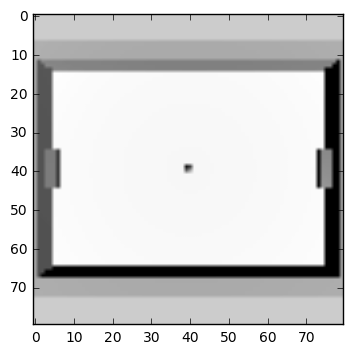

In [10]:
# Initial parameters
Replay_memory = []
step = 1
score = 0
score_board = 0
maxQ_sum = 0
maxQ_board = 0
loss_sum = 0
loss_board = 0

episode = 0
step_per_episode = 0

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]
observation_original = 255 * env_info.observations[0]
observation = 255 * env_info.observations[0]
observation = np.uint8(observation)
observation = np.reshape(observation, (80, 80, 3))
observation = resize_input(observation)

observation_in = np.zeros([img_size, img_size, Num_colorChannel * Num_stackFrame])
observation_next_in = np.zeros([img_size, img_size, Num_colorChannel * Num_stackFrame])

observation_set = []

start_time = time.time()

for i in range(Num_skipFrame * Num_stackFrame):
	observation_set.append(observation)
    
plt.imshow(observation, cmap = 'gray')

### Training

In [11]:
test_score = []

check_plot = 0

# Training & Testing
while True:
    if step <= Num_start_training:
        # Observation
        progress = 'Observing'
        train_mode = True

        action = np.zeros([Num_action])
        action[random.randint(0, Num_action - 1)] = 1.0
        action_in = [np.argmax(action)]

        env_info = env.step(action_in)[default_brain]

        observation_next = 255.0 * env_info.observations[0]
        observation_next = np.uint8(observation_next)
        observation_next = np.reshape(observation_next, (80, 80, 3))
        observation_next = resize_input(observation_next)
        reward = env_info.rewards[0]
        terminal = env_info.local_done[0]
        
        observation_set.append(observation_next)

        observation_next_in = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame))

        # Stack the frame according to the number of skipping frame
        for stack_frame in range(Num_stackFrame):
            observation_next_in[:,:,stack_frame] = observation_set[-1 - (Num_skipFrame * stack_frame)]

        del observation_set[0]

        observation_next_in = np.uint8(observation_next_in)
        
    elif step <= Num_start_training + Num_training:
        # Training
        progress = 'Training'
        train_mode = True

        # if random value(0 - 1) is smaller than Epsilon, action is random. Otherwise, action is the one which has the largest Q value
        Q_value = output.eval(feed_dict={x_image: [observation_in]})
        
        if random.random() < Epsilon:
            action = np.zeros([Num_action])
            action[random.randint(0, Num_action - 1)] = 1
        else:
            action = np.zeros([Num_action])
            action[np.argmax(Q_value)] = 1

        action_in = [np.argmax(action)]

        env_info = env.step(action_in)[default_brain]

        observation_next = 255.0 * env_info.observations[0]
        observation_next = np.uint8(observation_next)
        observation_next = np.reshape(observation_next, (80, 80, 3))
        observation_next = resize_input(observation_next)
        reward = env_info.rewards[0]
        terminal = env_info.local_done[0]

        observation_set.append(observation_next)

        observation_next_in = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame))

        # Stack the frame according to the number of skipping frame
        for stack_frame in range(Num_stackFrame):
            observation_next_in[:,:,stack_frame] = observation_set[-1 - (Num_skipFrame * stack_frame)]

        del observation_set[0]

        observation_next_in = np.uint8(observation_next_in)

        # Decrease the epsilon value
        if Epsilon > Final_epsilon:
            Epsilon -= 1.0/Num_training

        # Select minibatch
        minibatch =  random.sample(Replay_memory, Num_batch)

        # Save the each batch data
        observation_batch      = [batch[0] for batch in minibatch]
        action_batch           = [batch[1] for batch in minibatch]
        reward_batch           = [batch[2] for batch in minibatch]
        observation_next_batch = [batch[3] for batch in minibatch]
        terminal_batch 	       = [batch[4] for batch in minibatch]

        # Update target network according to the Num_update value
        if step % Num_update == 0:
            assign_network_to_target()

        # Get y_prediction
        y_batch = []
        Q_batch = output_target.eval(feed_dict = {x_image: observation_next_batch})
        for i in range(len(minibatch)):
            if terminal_batch[i] == True:
                y_batch.append(reward_batch[i])
            else:
                y_batch.append(reward_batch[i] + Gamma * np.max(Q_batch[i]))

        _, loss = sess.run([train_step, Loss], feed_dict = {action_target: action_batch, y_prediction: y_batch, x_image: observation_batch})

#         # save progress every 10000 iterations
#         if step % Num_step_save == 0:
#             saver.save(sess, 'saved_networks/' + date_time + '/' + algorithm)
#             print('Model is saved!!!')

    elif step < Num_start_training + Num_training + Num_test:
        # Testing
        progress = 'Testing'
        train_mode = False
        Epsilon = 0

        # Choose the action of testing state
        Q_value = output.eval(feed_dict={x_image: [observation_in]})
        action = np.zeros([Num_action])
        action[np.argmax(Q_value)] = 1


        # Get game state
        action_in = [np.argmax(action)]

        env_info = env.step(action_in)[default_brain]

        observation_next = 255.0 * env_info.observations[0]
        observation_next = np.uint8(observation_next)
        observation_next = np.reshape(observation_next, (80, 80, 3))
        observation_next = resize_input(observation_next)
        reward = env_info.rewards[0]
        terminal = env_info.local_done[0]

        observation_set.append(observation_next)

        observation_next_in = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame))

        # Stack the frame according to the number of skipping frame
        for stack_frame in range(Num_stackFrame):
            observation_next_in[:,:,stack_frame] = observation_set[-1 - (Num_skipFrame * stack_frame)]

        del observation_set[0]

        observation_next_in = np.uint8(observation_next_in)

    else:
        print('Finished!!')
        env.close()
        break

    # If length of replay memeory is more than the setting value then remove the first one
    if len(Replay_memory) > Num_replay_memory:
        del Replay_memory[0]

    # Save experience to the Replay memory
    if progress != 'Testing':
        Replay_memory.append([observation_in, action, reward, observation_next_in, terminal])
    
    step += 1
    score += reward
    step_per_episode += 1
    observation_in = observation_next_in

    if progress != 'Observing':
        maxQ_sum += np.max(Q_value)
        loss_sum += loss
        
        if episode % Num_plot_episode == 0 and check_plot ==1 and episode != 0:
            tensorboard_info = [score_board / Num_plot_episode, Epsilon, maxQ_board / Num_plot_episode, loss_board / Num_plot_episode]
            for i in range(len(tensorboard_info)):
                sess.run(update_ops[i], feed_dict = {summary_placeholders[i]: float(tensorboard_info[i])})
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, step)
            score_board = 0
            check_plot = 0
            
    # If terminal is True
    if terminal == True:
        # Print informations
        print('step: ' + str(step) + ' / '  + 'episode: ' + str(episode) + ' / ' + 'progress: ' + progress  + ' / '  + 'epsilon: ' + str(Epsilon) + ' / '  + 'score: ' + str(score))

        check_plot = 1

        # If progress is testing then add score for calculating test score
        if progress == 'Testing':
            test_score.append(score)

        if progress != 'Observing':
            episode += 1
            
            score_board += score
            maxQ_board += maxQ_sum / step_per_episode
            loss_board += loss_sum / step_per_episode
            
        score = 0
        step_per_episode = 0

        # Initialize game state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        observation = 255.0 * env_info.observations[0]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (80, 80, 3))
        observation = resize_input(observation)

        observation_set = []

        for i in range(Num_skipFrame * Num_stackFrame):
                observation_set.append(observation)


step: 63 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 125 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 187 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 357 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 527 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 589 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 651 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 821 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 988 / episode: 0 / progress: Observing / epsilon: 1 / score: 5.0
step: 1158 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 1328 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 1390 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 1560 / episode: 0 / progress: Observing / epsilon: 1 / score: -1.0
step: 1622 / episode: 0 / progress: Observing / epsilon: 1 / s